# Libraries & Introduction

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import json
import os

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from spellchecker import SpellChecker

# Deep learning
import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import keras_tuner
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters





# Machine Learning and Metrics
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score,
    confusion_matrix
)
from sklearn.model_selection import train_test_split

# Utility
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

C:\Users\micha\AppData\Local\Temp\ipykernel_21000\3331316496.py:29: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Download required NLTK data unless present
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("Downloading required NLTK data...")
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("Download complete!")

In [3]:
# First we want to crack into the data and see what we're working with
train_data_frame = pd.read_csv('train.csv')
train_data_frame.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


With this in mind lets check back in on the purpose of the Kaggle Competition.</br>
</br>
https://www.kaggle.com/c/nlp-getting-started/overview</br>
</br>
In this competition, you're challenged to build a machine learning model that predicts which Tweets are about real disasters and which one's aren't. You'll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.</br>
</br>
Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.</br>
</br>
Now we want to state the class guidelines:</br>
</br>
Deliverable 1</br>
</br>
A Jupyter notebook with a description of the problem/data, exploratory data analysis (EDA) procedure, analysis (model building and training), result, and discussion/conclusion.</br>
</br>
Suppose your work becomes so large that it doesn't fit into one notebook (or you think it will be less readable by having one large notebook). In that case, you can make several notebooks or scripts in a GitHub repository (as deliverable 3) and submit a report-style notebook or pdf instead.</br>
</br>
If your project doesn't fit into Jupyter notebook format (E.g., you built an app that uses ML), write your approach as a report and submit it in a pdf form.</br>
</br>
Deliverable 2</br>
</br>
A public project GitHub repository with your work (please also include the GitHub repo URL in your notebook/report).</br>
</br>
Deliverable 3</br>
</br>
A screenshot of your position on the Kaggle competition leaderboard for your top-performing model.</br>
</br>
Step Breakdown:</br>
</br>
Step 1</br>
Brief description of the problem and data (5 pts)</br>
</br>
Step 2</br>
Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)</br>
</br>
Step 3</br>
Model Architecture (25 pts)</br>
</br>
Step 4</br>
Results and Analysis (35 pts)</br>
</br>
Step 5</br>
Discussion and Conclusion (15 pts)</br>
</br>
Extra Rules described above in the deliverables section</br>
Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard (30 points)


For my approach I am going to do some simple Data exploration and make sure everythings all clean. Then we'll clean out the filler words and run the standard data statistics on our variables. Then we'll construct a word cloud for an extra layer of analysis.
</br>

Next we'll split up our data and then prepare for oru LSTM model. Once this is finished we will explore a TF-IDF model and see how it compares.


# Data Load & EDA

In [4]:
# quick clean
print(len(train_data_frame))
# 1. remove duplicates
train_data_frame = train_data_frame.drop_duplicates()
print(len(train_data_frame))
# 2. remove empty rows
train_data_frame = train_data_frame[train_data_frame['text'].notna()]
print(len(train_data_frame))

7613
7613
7613


From this point it looks like the data matches the implied level of quality infered by the Kaggle Contest page and the data sets 'data card'.
Next I want to address the two rows displayed above in the head(). The 'keyword' and 'location' columns display NaN, and this could complicate things. Lets chek and see if any data is present. 



In [5]:
# check the distribution of values in the keyword column
kayword_counts = pd.DataFrame(train_data_frame['keyword'].value_counts())
kayword_counts = kayword_counts.sort_values(by='count', ascending=False)
print(kayword_counts.head(10))

# check the distribution of values in the location column
location_counts = pd.DataFrame(train_data_frame['location'].value_counts())
location_counts = location_counts.sort_values(by='count', ascending=False)
print(location_counts.head(10))

# percentage of missing values of rows in 'keyword' and 'location' columns 
print((221/len(train_data_frame))*100, '% of rows contain values in the keyword column')
print((3341/len(train_data_frame))*100, '% of rows contain values in the location column')


             count
keyword           
fatalities      45
deluge          42
armageddon      42
damage          41
body%20bags     41
harm            41
sinking         41
evacuate        40
outbreak        40
fear            40
                 count
location              
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
2.902929200052542 % of rows contain values in the keyword column
43.885459083147246 % of rows contain values in the location column


As we can see there is some issues with the fact that only 2% of the rows contain values in the keyword column. 

In [6]:
#
# next we remove the stopwords
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords



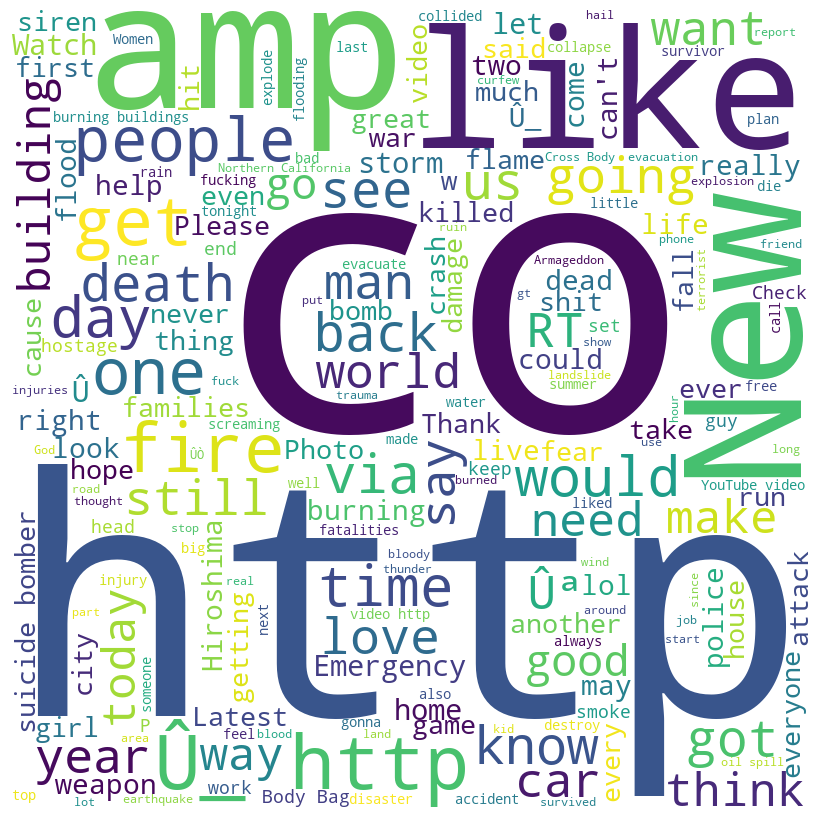

In [7]:
# Create a word cloud visualization
text = ' '.join(train_data_frame['text'])
wordcloud = WordCloud(width=800, height=800, 
                      background_color='white',
                      stopwords=stop_words, 
                      min_font_size=10).generate(text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


## There is probably no better example of the need for cleaning in our dataset than viewing this. Not only is the most common word clearly http, but you can also see the number of characters the wordcloud was not able to interpret. 

# Cleaning data

In [8]:
test_data_frame = pd.read_csv('test.csv')
test_data_frame.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# function to process and clean tweets
def preprocess_data(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords and stem
    stemmer = nltk.stem.porter.PorterStemmer()
    text = ' '.join(stemmer.stem(word) for word in tokens if word not in stop_words)
    
    return text

In [10]:
# Function to perform spell check
def correct_spelling(text):
    spell = SpellChecker()
    corrected_words = []
    # for every word review and replace if mis-spelled
    for word in text.split():
        corrected_word = spell.correction(word)
        if corrected_word is not None:
            corrected_words.append(corrected_word)
        else:
            corrected_words.append(word)  # Keep the original word if correction is None
    return " ".join(corrected_words)

In [11]:
# next we handle emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


In [12]:
# Cleaning text
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [13]:
# helper function to display the mean number of words in a tweet in each row of the dataset
def mean_words(text):
    return len(text.split(' '))

# calculate the mean number of words in the dataset
train_data_frame['mean_words']=train_data_frame['text'].apply(lambda x: mean_words(x))
test_data_frame['mean_words']=test_data_frame['text'].apply(lambda x: mean_words(x))


In [14]:

# Create directory for processed data if it doesn't exist
os.makedirs('processed_data', exist_ok=True)

# Check if preprocessed train data exists
if os.path.exists('processed_data/preprocessed_train.csv'):
    print("Loading preprocessed training data from file...")
    train_data_frame = pd.read_csv('processed_data/preprocessed_train.csv')
    print("Preprocessed training data loaded successfully!")
    # Display the head to confirm it loaded correctly
    train_data_frame.head()
else:
    print("Preprocessed training data not found. Will run preprocessing steps...")

Preprocessed training data not found. Will run preprocessing steps...


In [ ]:
# Only run the preprocessing steps if we don't have the preprocessed file
if not os.path.exists('processed_data/preprocessed_train.csv'):
    # Download required NLTK data
    nltk.download('punkt_tab')
    train_data_frame['clean_text']=train_data_frame['text'].apply(lambda x: remove_emoji(x))

    # remove stopwords  
    train_data_frame['clean_text']=train_data_frame['clean_text'].apply(lambda x: preprocess_data(x))

    # remove extra whitespace
    train_data_frame['clean_text']=train_data_frame['clean_text'].apply(lambda x: re.sub(r'\s+', ' ', x))

    # Spellcheck
    train_data_frame['clean_text'] = train_data_frame['clean_text'].apply(correct_spelling)
    
    # Save the preprocessed dataframe
    train_data_frame.to_csv('processed_data/preprocessed_train.csv', index=False)
    print("Preprocessed training data saved to 'processed_data/preprocessed_train.csv'")

# Display the head of the dataframe
train_data_frame.head()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Check if preprocessed test data exists
if os.path.exists('processed_data/preprocessed_test.csv'):
    print("Loading preprocessed test data from file...")
    test_data_frame = pd.read_csv('processed_data/preprocessed_test.csv')
    print("Preprocessed test data loaded successfully!")
    # Display the head to confirm it loaded correctly
    test_data_frame.head()
else:
    print("Preprocessed test data not found. Will run preprocessing steps...")

In [ ]:
if not os.path.exists('processed_data/preprocessed_test.csv'):
    # remove emojies
    test_data_frame['clean_text']=test_data_frame['text'].apply(lambda x: remove_emoji(x))

    # remove stopwords  
    test_data_frame['clean_text']=test_data_frame['clean_text'].apply(lambda x: preprocess_data(x))

    # remove extra whitespace
    test_data_frame['clean_text']=test_data_frame['clean_text'].apply(lambda x: re.sub(r'\s+', ' ', x))

    # Spellcheck
    test_data_frame['clean_text'] = test_data_frame['clean_text'].apply(correct_spelling)
    
    # Save the preprocessed dataframe
    test_data_frame.to_csv('processed_data/preprocessed_test.csv', index=False)
    print("Preprocessed test data saved to 'processed_data/preprocessed_test.csv'")

# Display the head of the dataframe
test_data_frame.head()

KeyboardInterrupt: 

In [15]:

# remove stopwords  
train_data_frame['clean_text']=train_data_frame['clean_text'].apply(lambda x: remove_stopwords(x))
test_data_frame['clean_text']=test_data_frame['clean_text'].apply(lambda x: remove_stopwords(x))
train_data_frame.head()
train_tweets = train_data_frame['clean_text'].values
test_tweets = test_data_frame['clean_text'].values
train_target = train_data_frame['target'].values

,id,keyword,location,text,target,mean_words,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la long sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,reside ask shelter place notify office shelter...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,people receive wildfire order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rub alaska smoke wildfire pour ...


# Helper Funcitons and Architecture

In [17]:
# Create f1 score calculator
def f11_score_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_val

In [50]:
# remade funciton
def f1_score_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    
    true_pos = tf.reduce_sum(y_true * y_pred)
    false_pos = tf.reduce_sum((1 - y_true) * y_pred)
    false_neg = tf.reduce_sum(y_true * (1 - y_pred))
    
    precision = true_pos / (true_pos + false_pos + tf.keras.backend.epsilon())
    recall = true_pos / (true_pos + false_neg + tf.keras.backend.epsilon())
    
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [18]:
# Tokenize our words
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

11464

# Corpus Creation

The Corpus unites our functions together for cleaning and tokenizing, whilst also serving the purpose of preparing our data training dataframe in a manner that ready for a model to process. For each Tweat we'll tokenize with the NLTK Library pulled from above and ensure our words ar in the final clean stated. What we have left is our list of lists!

This is perfect also for allowing us to study word embeddings. These are desnse vector representations of words that capture the semantic relationships between themselves. 

In [19]:
# 
def create_corpus(df):
    corpus=[]
    for tweet in tqdm.tqdm(df['clean_text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop_words))]
        corpus.append(words)
    return corpus

In [20]:
train_corpus = create_corpus(pd.DataFrame({'clean_text': train_tweets}))


100%|██████████| 7613/7613 [00:00<00:00, 21274.63it/s]


In [21]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

NMow next what we have to do is prepare for our embedding and simultaneously padd our tweets. What this does is ensure that our tweets are all the appropriate size for our Neural Network, as the input sizes must be controlled.

In [22]:
longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(train_tweets), length_long_sentence, padding='post')
test_sentences = pad_sequences(
    embed(test_tweets), 
    length_long_sentence,
    padding='post'
)

In [23]:
embeddings_dict = dict()
embedding_dim = 100
with open('G:/My Drive/Academia/MSDS/Machine Learning Specialization/DTSA5511 Deep Learning/glove.twitter.27B/glove.twitter.27B.100d.txt', encoding='utf-8') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dict [word] = vector_dimensions


In [24]:
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.21063   , -0.010992  , -0.17552   , ..., -0.37547001,
         0.58029002,  0.16067   ],
       [ 0.066373  ,  1.09249997, -0.59674001, ...,  0.040076  ,
        -0.12083   , -0.1785    ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.20201001,  0.53070003, -0.15939   , ..., -0.44692001,
         0.20909999, -0.4914    ],
       [-0.076711  , -0.77710998, -0.75962001, ...,  0.23106   ,
         0.09527   , -0.15951   ]])

In [25]:
# Data is ready, lets split!
X_train, X_val, y_train, y_val = train_test_split(
    padded_sentences, 
    train_target, 
    test_size=0.25
)

In [26]:
# I wanted to create a function that allows us to leverage the fact that I'm training models and want to build on them continuously. 
# This will look for any saved models on my local machine. Then it checks to see if a training log exists

def load_or_create_model():
    model_path = 'dt_model_final.keras'
    
    try:
        # Attempt to load existing model
        print("Attempting to load existing model...")
        model = load_model(model_path)
        print("Existing model loaded successfully!")
        
        # Optionally load training history
        try:
            with open('training_history.json', 'r') as f:
                history = json.load(f)
            print("Training history loaded successfully!")
        except FileNotFoundError:
            history = None
            print("No training history found.")
            
        return model, history, False  # False indicates no training needed
        
    except (OSError, IOError, ValueError):
        print("No existing model found. Creating new model...")
        model = glove_lstm()
        return model, None, True  # True indicates training is needed

# Model: Long Short Term Memory

As perscribed in the week 4 lectures I decided to leverage the LSTM method of deep learning to process our LAnguage task. These are especially well suited for natural language processing as, you can imagine, we can get pretty long winded as a species. Trying to capture the relationship between words can get insanely complex the more you try and examine the relationships for each word added. LSTM has a memory cell which allows it to avoid the pitfalls of vanishing  or exploding gradients, being able to return to a point and try another direciton.

Now I chose Glove LSTM as this allows for Glove embeddings. As I described through the comments, Glove will allow us to capture the semantic relationship with words and create embedding matricies. Ill be tapping into the glove.twitter.27B.100d.txt library.

Lastly, I chose bidirectional LSTM so that I'm xamining the relationships both moving backwards and forwards (The model isn't only taking into account words from the future, but also what's already been said).

The first bidirectional LSTM layer has 128 units and returns sequences, meaning it outputs a sequence of hidden states for each time step. The second bidirectional LSTM layer has 64 units and returns only the final hidden state.

The dense layers are used for further processing and classification. The first dense layer has 32 units with ReLU activation, followed by a dropout layer to prevent overfitting. The final dense layer has a single unit with sigmoid activation, which outputs the probability of the input sequence belonging to the positive class.

In [27]:
# Define our Glove LSTM PArameters
def glove_lstm():
    model = Sequential()
    
    # Add embedding layer
    model.add(Embedding(
        vocab_length,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=length_long_sentence,
        trainable=False
    ))
    
    # Add LSTM layers
    model.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)))
    model.add(tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2)))
    
    # Add Dense layers
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [46]:
# For saving / loading the model
model_path = 'dt_model_final.keras'
model = tf.keras.models.load_model(model_path)

In [47]:
# Call our Function to see if a model exists

model, history, needs_training = load_or_create_model()

if needs_training:
    # Update the checkpoint to save in .keras format 
    checkpoint = ModelCheckpoint(
        'dt_model_final.keras',  
        monitor='val_loss',
        verbose=1,
        save_best_only=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        verbose=1,
        patience=5,
        min_lr=0.001
    )

    # Save training history
    history = model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[reduce_lr, checkpoint]
    )

    # Save to file
    with open('training_history.json', 'w') as f:
        json.dump(history.history, f)

    # Save the final model
    model.save('dt_model_final.keras')
else:
    print("Using pre-trained model. Skipping training phase.")



Attempting to load existing model...
Existing model loaded successfully!
Training history loaded successfully!
Using pre-trained model. Skipping training phase.


In [48]:
# Build the Glove LSTM using the architecture we made above
def build_model(hp):
    model = Sequential()
    
    # Add embedding layer
    model.add(Embedding(
        vocab_length,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=length_long_sentence,
        trainable=False
    ))
    
    # Add LSTM layers with tunable parameters
    model.add(tf.keras.layers.Bidirectional(
        LSTM(hp.Int('lstm_units_1', min_value=64, max_value=128, step=32), 
        return_sequences=True, 
        dropout=hp.Float('dropout_1', min_value=0.10, max_value=0.30, step=0.1))
    ))
    model.add(tf.keras.layers.Bidirectional(
        LSTM(hp.Int('lstm_units_2', min_value=32, max_value=64, step=16), 
        dropout=hp.Float('dropout_2', min_value=0.10, max_value=0.30, step=0.1))
    ))
    
    # Add Dense layers
    model.add(Dense(hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy', f1_score_metric]
    )
    

    return model

In [ ]:


def load_tuner_results(directory='tuner_results', project_name='disaster_tweets'):
    """Load the results from a Keras Tuner search."""
    tuner_dir = os.path.join(directory, project_name)
    
    # Dictionary to store trial data
    trials_data = {}
    
    # Walk through the directory to find trial folders
    for root, dirs, files in os.walk(tuner_dir):
        if 'trial.json' in files:
            # Load the trial.json file
            with open(os.path.join(root, 'trial.json'), 'r') as f:
                trial_data = json.load(f)
            
            trial_id = os.path.basename(root)
            
            # Extract metrics if available
            if 'metrics' in trial_data and 'metrics' in trial_data['metrics']:
                metrics = trial_data['metrics']['metrics']
                
                # Look for val_f1_score_metric
                if 'val_f1_score_metric' in metrics:
                    f1_values = metrics['val_f1_score_metric']
                    
                    # Store the best F1 score for this trial
                    if f1_values:
                        best_f1 = max(f1_values)
                        trials_data[trial_id] = {
                            'best_f1': best_f1,
                            'f1_history': f1_values,
                            'hyperparameters': trial_data.get('hyperparameters', {})
                        }
    
    return trials_data

def visualize_f1_progression(trials_data):
    """Visualize the progression of F1 scores across trials."""
    if not trials_data:
        print("No trial data found with F1 scores.")
        return
    
    # Sort trials by ID
    sorted_trials = sorted(trials_data.items(), key=lambda x: x[0])
    trial_ids = [trial_id for trial_id, _ in sorted_trials]
    best_f1_scores = [data['best_f1'] for _, data in sorted_trials]
    
    # Find the best trial
    best_f1 = max(best_f1_scores)
    best_trial_idx = best_f1_scores.index(best_f1)
    best_trial_id = trial_ids[best_trial_idx]
    
    # Create the line plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(trial_ids) + 1), best_f1_scores, 'bo-', linewidth=2, markersize=8)
    plt.axhline(y=best_f1, color='r', linestyle='--', 
                label=f'Best F1: {best_f1:.4f} (Trial {best_trial_id})')
    
    # Add labels for each point
    for i, (_, f1) in enumerate(zip(trial_ids, best_f1_scores)):
        plt.annotate(f'{f1:.4f}', (i + 1, f1), textcoords="offset points", 
                    xytext=(0, 10), ha='center')
    
    plt.xlabel('Trial Number')
    plt.ylabel('Best Validation F1 Score')
    plt.title('F1 Score Progression During Hyperparameter Search')
    plt.xticks(range(1, len(trial_ids) + 1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('f1_score_progression.png')
    plt.show()
    
    # Create the bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(1, len(trial_ids) + 1), best_f1_scores, color='skyblue')
    
    # Highlight the best trial
    bars[best_trial_idx].set_color('green')
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.4f}', ha='center', va='bottom', rotation=0)
    
    plt.axhline(y=best_f1, color='r', linestyle='--', 
                label=f'Best F1: {best_f1:.4f} (Trial {best_trial_id})')
    
    plt.xlabel('Trial Number')
    plt.ylabel('Best Validation F1 Score')
    plt.title('F1 Score Comparison Across Trials')
    plt.xticks(range(1, len(trial_ids) + 1))
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.savefig('f1_score_comparison.png')
    plt.show()
    
    return best_trial_id, best_f1

def visualize_f1_during_training(trials_data, trial_id=None):
    """Visualize F1 scores during training for a specific trial or all trials."""
    if not trials_data:
        print("No trial data found with F1 scores.")
        return
    
    plt.figure(figsize=(12, 6))
    
    if trial_id and trial_id in trials_data:
        # Visualize a specific trial
        f1_history = trials_data[trial_id]['f1_history']
        epochs = range(1, len(f1_history) + 1)
        plt.plot(epochs, f1_history, 'bo-', linewidth=2, label=f'Trial {trial_id}')
        plt.title(f'F1 Score During Training for Trial {trial_id}')
    else:
        # Visualize all trials
        for trial_id, data in trials_data.items():
            f1_history = data['f1_history']
            epochs = range(1, len(f1_history) + 1)
            plt.plot(epochs, f1_history, 'o-', linewidth=1, label=f'Trial {trial_id}')
        plt.title('F1 Score During Training for All Trials')
    
    plt.xlabel('Epoch')
    plt.ylabel('Validation F1 Score')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    if trial_id:
        plt.savefig(f'f1_score_training_trial_{trial_id}.png')
    else:
        plt.savefig('f1_score_training_all_trials.png')
    
    plt.show()

def main():
    # Load the tuner results
    trials_data = load_tuner_results()
    
    if not trials_data:
        print("No trial data found. Make sure the tuner_results directory exists and contains trial data.")
        return
    
    print(f"Found {len(trials_data)} trials with F1 score data.")
    
    # Visualize F1 score progression across trials
    best_trial_id, best_f1 = visualize_f1_progression(trials_data)
    
    print(f"Best trial: {best_trial_id} with F1 score: {best_f1:.4f}")
    
    # Visualize F1 scores during training for the best trial
    visualize_f1_during_training(trials_data, best_trial_id)
    
    # Visualize F1 scores during training for all trials
    visualize_f1_during_training(trials_data)

if __name__ == "__main__":
    main() 

# Hyper Parameter Tuning and Results

The wonderful people over at Keras provided the Keras Tuner library, making the grid searching so much easier. For this we focus the f1 score, which we define a function for above. Combining these both and using the history tool we can train our model and recall the best one to continue it's improvement. 

In [51]:
# Build our tuner! This will cycle through all of our combinations
objective_f1 = keras_tuner.Objective('val_f1_score_metric', "max")
tuner = RandomSearch(
    build_model,
    objective=objective_f1,
    max_trials=10,
    executions_per_trial=4,
    directory='tuner_results',
    project_name='disaster_tweets'
)


tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val))
best_model = tuner.get_best_models(num_models=1)[0]

# Visualize F1 scores from the hyperparameter search
def visualize_f1_scores_from_tuner():
    # Get the trials directory
    tuner_dir = os.path.join('tuner_results', 'disaster_tweets')
    
    # Dictionary to store trial data
    trials_data = {}
    
    # Walk through the directory to find trial folders
    for root, dirs, files in os.walk(tuner_dir):
        if 'trial.json' in files:
            # Load the trial.json file
            with open(os.path.join(root, 'trial.json'), 'r') as f:
                trial_data = json.load(f)
            
            trial_id = os.path.basename(root).split('_')[-1]  # Extract trial number
            
            # Extract metrics if available
            if 'metrics' in trial_data and 'metrics' in trial_data['metrics']:
                metrics = trial_data['metrics']['metrics']
                
                # Look for val_f1_score_metric
                if 'val_f1_score_metric' in metrics:
                    f1_values = metrics['val_f1_score_metric']
                    
                    # Store the best F1 score for this trial
                    if f1_values:
                        best_f1 = max(f1_values)
                        trials_data[int(trial_id)] = {
                            'best_f1': best_f1,
                            'f1_history': f1_values
                        }
    
    if not trials_data:
        print("No trial data found with F1 scores.")
        return None, None
    
    # Sort trials by ID
    sorted_trials = sorted(trials_data.items())
    trial_ids = [trial_id for trial_id, _ in sorted_trials]
    best_f1_scores = [data['best_f1'] for _, data in sorted_trials]
    
    # Find the best trial
    best_f1 = max(best_f1_scores)
    best_trial_idx = best_f1_scores.index(best_f1)
    best_trial_id = trial_ids[best_trial_idx]
    
    # Create the bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(trial_ids, best_f1_scores, color='skyblue')
    
    # Highlight the best trial
    bars[best_trial_idx].set_color('green')
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.4f}', ha='center', va='bottom', rotation=0)
    
    plt.axhline(y=best_f1, color='r', linestyle='--', 
                label=f'Best F1: {best_f1:.4f} (Trial {best_trial_id})')
    
    plt.xlabel('Trial Number')
    plt.ylabel('Best Validation F1 Score')
    plt.title('F1 Score Comparison Across Trials')
    plt.xticks(trial_ids)
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Create the line plot to show progression
    plt.figure(figsize=(12, 6))
    plt.plot(trial_ids, best_f1_scores, 'bo-', linewidth=2, markersize=8)
    plt.axhline(y=best_f1, color='r', linestyle='--', 
                label=f'Best F1: {best_f1:.4f} (Trial {best_trial_id})')
    
    # Add labels for each point
    for i, (_, f1) in enumerate(zip(trial_ids, best_f1_scores)):
        plt.annotate(f'{f1:.4f}', (trial_ids[i], f1), textcoords="offset points", 
                    xytext=(0, 10), ha='center')
    
    plt.xlabel('Trial Number')
    plt.ylabel('Best Validation F1 Score')
    plt.title('F1 Score Progression During Hyperparameter Search')
    plt.xticks(trial_ids)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Visualize F1 scores during training for the best trial
    plt.figure(figsize=(12, 6))
    f1_history = trials_data[best_trial_id]['f1_history']
    epochs = range(1, len(f1_history) + 1)
    plt.plot(epochs, f1_history, 'bo-', linewidth=2)
    plt.title(f'F1 Score During Training for Best Trial ({best_trial_id})')
    plt.xlabel('Epoch')
    plt.ylabel('Validation F1 Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return best_trial_id, best_f1

# Run the visualization
best_trial_id, best_f1 = visualize_f1_scores_from_tuner()
print(f"Best trial: {best_trial_id} with F1 score: {best_f1:.4f}")

Trial 10 Complete [00h 03m 18s]
val_f1_score_metric: 0.4059727092583974

Best val_f1_score_metric So Far: 0.4357193609078725
Total elapsed time: 00h 30m 32s


In [52]:
# Review how well we did!
loss, accuracy = model.evaluate(X_val, y_val)
print('Loss:', loss)
print('Accuracy:', accuracy)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7969 - loss: 0.5079
Loss: 0.5049303770065308
Accuracy: 0.7998949289321899


In [53]:
submission = pd.read_csv('sample_submission.csv')


In [54]:
# Get predictions as probabilities
predictions = model.predict(test_sentences)
# Convert to binary (0 or 1) predictions using 0.5 threshold
submission.target = (predictions > 0.5).astype(int)
submission.to_csv("submission-v2.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


References

This one was a
https://www.kaggle.com/code/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm